In [256]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
from typing import List
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi')
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece

sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models')
import helper


In [257]:
# Return hidden score states 

note_info = process_midi_to_note_info('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Bach_1.midi')
dic = notes_to_chords(note_info, sustain=False)
score, time_to_next = dict_to_frequency_list(dic)
print(score)

[[262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [294], [440], [587], [698], [440], [587], [698], [262], [294], [440], [587], [698], [440], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [440], [659], [880], [440], [659], [880], [262], [330], [440], [659], [880], [440], [659], [880], [262], [294], [370], [440], [587], [370], [440], [587], [262], [294], [370], [440], [587], [370], [440], [587], [247], [294], [392], [587], [784], [392], [587], [784], [247], [294], [392], [587], [784], [392], [587], [784], [247], [262], [330], [392], [523], [330], [392], [523], [247], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392]

In [1]:
print(time_to_next)

NameError: name 'time_to_next' is not defined

In [258]:
# Create cov_dict

cov_dict = {}
sample_length = 1000
sample_rate = 44100
M=9
T=0.465
v=2.37
sigma_f=5
sigma_n=0.1
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)

for state in score[:20]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            time_samples, time_samples, M=M,  f=state, sigma_f=sigma_f, T=T, v=v) + sigma_n**2 * np.eye(sample_length)

In [276]:
# Create state transmission matrix, T. Here we are using uniform distribution as all notes are the same length
score_length = 55
# For now we will go with a very simple uniform distribution to the current or next state
K = len(score[:score_length]) # The number of states, K
T = np.zeros((K, K)) 
for i in range(K-1): # Populate transition probabilities except final row
    T[i][i], T[i][i+1] = np.log(0.5), np.log(0.5)
T[-1][-1] = np.log(1) # Update final row so transition probability is one, to itself



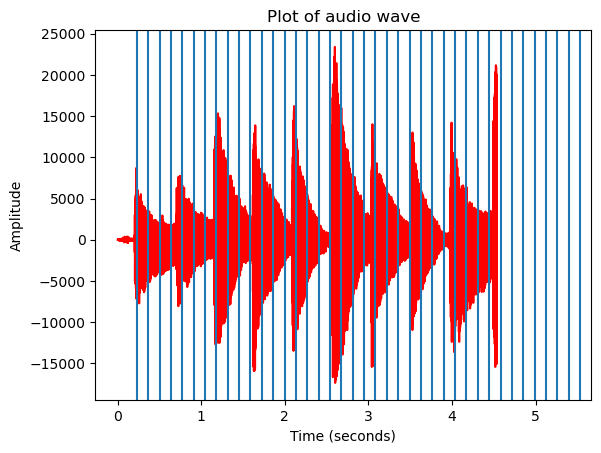

In [265]:
# Return observed state elements as a list of np.arrays called audio_data

# Define arguments
hop_length = 6000
sample_length = 1000
show = 200000
offset = 10000 # TODO Ive added an offset of 10000 for now whilst we havent implemented a solution for the initial silence

performance_path = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/bach_3.wav'
sample_rate, data = wav.read(performance_path)

performance_duration = len(data)/sample_rate

time_samples = np.linspace(0, performance_duration, len(data))
sample_indices = np.arange(offset, len(data), hop_length) 
audio_data = [data[index:index+sample_length] for index in sample_indices]

# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for i in sample_indices[:40]:
    plt.axvline(i/sample_rate)


In [282]:
def viterbi_attempt_2(y: List[np.ndarray], T: np.ndarray, states: List[list], padding: int = 6, sample_rate: int = 44100, cov_dict: dict = cov_dict):
    """
    Return the optimal state path of the Hidden Markov Model

    Parameters
    y: Observed state sequence
    T: State transition matrix (K, K) of K states
    E: Emission matrix?
    """

    sample_length = len(y[0]) # Assuming all samples are the same length
    time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
    n = len(y) # Number of audio samples
    K = T.shape[0] # Number of states
    gamma = np.full((K , n), -np.inf, 'd') # Matrix to hold probabilitie
    delta = np.zeros((K, n), 'B') # Back pointers 
    lml_matrix = np.full((K , n),-np.inf, 'd') # Matrix to hold probabilitie
    path = []

    # Initialise
    max_s = 0
    lml = -helper.stable_nlml(time_samples, y[0], M=9, normalised=False, f=states[0], T=0.465, v=2.37, cov_dict=cov_dict)  
    gamma[0, 0] = lml

    
    for i in range(1, n):
        min_state = max_s - padding
        max_state = max_s + padding

        # calculate lmls for relevant states
        for k in range(min_state, max_state):
            if 0 <= k < len(states):
                lml = -helper.stable_nlml(time_samples, y[i], M=9, normalised=False, f=states[k], T=0.465, v=2.37, cov_dict=cov_dict)  
                lml_matrix[k,i] =lml
        
        # now calculate cumulative probabilities
        for k in range(min_state, max_state):
            if k == 0:
                gamma[k, i] = lml_matrix[k, i] + T[k, k] + gamma[k, i-1]
                delta[k, i] = k # pointer to previous state
                
            if 0 < k < len(states):
                same_state = lml_matrix[k, i] + T[k, k] + gamma[k, i-1]
                advance_state = lml_matrix[k, i] + T[k-1, k] + gamma[k-1, i-1]
                if advance_state > same_state:
                    gamma[k, i] = advance_state
                    delta[k, i] = k # pointer to previous state
                else:
                    gamma[k, i] = same_state
                    delta[k, i] = k -1 # pointer to previous state
            
        max_s = np.argmax(gamma[:, i])
        path.append(max_s)
    s = np.zeros(n, 'B') # 'B' means they are integers
    s[-1] = np.argmax(gamma[:, n-1])
    # Populate s according to the pointers in delta
    for i in reversed(range(1, n)):
        s[i-1] = delta[s[i],i]

    return path, s



path,s = viterbi_attempt_2(audio_data[:25], T, score[:25]) # TODO T shouold really be constructed within this function

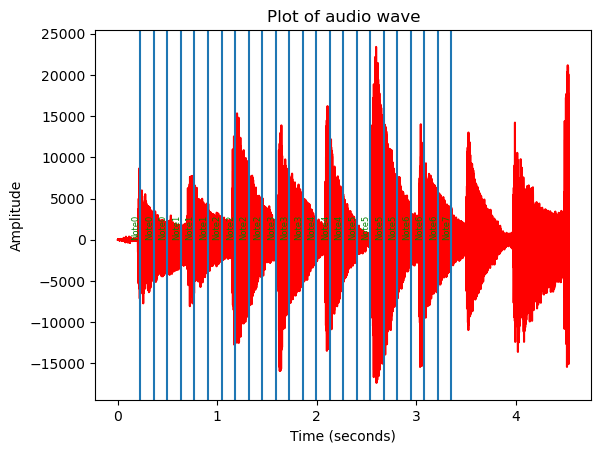

In [285]:
# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for _, i in enumerate(sample_indices[:24]):
    plt.axvline(i/sample_rate)
    plt.text(sample_indices[_]/sample_rate, 0.3, f'Note{path[_]}', color='green', ha='right', va='bottom', rotation=90, fontsize=6)
    

In [ ]:
def viterbi(y: List[np.ndarray], T: np.ndarray, states: List[list], padding: int = 3, sample_rate: int = 44100, cov_dict: dict = cov_dict):
    """
    Return the optimal state path of the Hidden Markov Model

    Parameters
    y: Observed state sequence
    T: State transition matrix (K, K) of K states
    E: Emission matrix?
    """

    sample_length = len(y[0]) # Assuming all samples are the same length
    time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
    w = 2 * padding + 1
    K = T.shape[0] # Number of states
    n = len(y) # Number of audio samples
    gamma = np.zeros((w , 1), 'd') # Matrix to hold probabilitie
    prev_gamma = np.zeros((w , 1), 'd')
    lml_vector = np.zeros((w,1), 'd') # Matrix to hold probabilitie
    max_s = 0 # Initialise state tracker at 0
    path = []
    
    for i in range(n):
        # Calculate all the relevant lmls
        for j in range(w):
            state_index = max_s - padding + j
            if len(states) > state_index >=  0:
                lml_vector[j] = -helper.stable_nlml(time_samples, y[i], M=9, normalised=False, f=states[state_index], T=0.465, v=2.37, cov_dict=cov_dict)  
            else: # to catch initial states 
                lml_vector[j] = 0

        # Now calculate the max probabilities in gamma
        for j in range(w):
            state_index = state_index
            if len(states) > state_index >=  0 and state_index < T.shape[0]:
                same_state = lml_vector[j] + T[state_index, state_index] + prev_gamma[j]
                advance_state = lml_vector[j] + T[state_index-1 , state_index] + prev_gamma[np.max([0,j - 1])]
                if advance_state < same_state:
                    gamma[j] = advance_state
                else:
                    gamma[j] = same_state
            else: # Set probabilities to zero if the state doesn't exist
                gamma[j] =-np.inf

        max_index = np.argmax(gamma)
        max_s = max_index + max_s - padding 
        prev_gamma = gamma
        path.append(max_s)
    print(path)
  
    return path

    # for j in range(no_samples):


viterbi(audio_data[:15], T, score[:100])



    

[-3, -6, -9, -12, -15, -18, -21, -24, -27, -30, -33, -36, -39, -42, -45]


[-3, -6, -9, -12, -15, -18, -21, -24, -27, -30, -33, -36, -39, -42, -45]

In [ ]:
print(path)

NameError: name 'path' is not defined

In [ ]:
import time

tim1 = time.time()
for i in range(7):
    print(-helper.stable_nlml(time_samples, audio_data[0], M=9, normalised=False, f=[440], T=0.465, v=2.37, cov_dict=cov_dict)  )
tim2 = time.time()
print(tim2 - tim1)

-229852582156.66766
-229852582156.66766
-229852582156.66766
-229852582156.66766
-229852582156.66766
-229852582156.66766
-229852582156.66766
0.11728572845458984


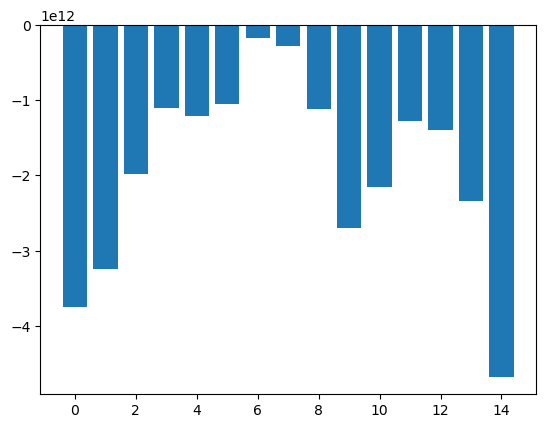

In [ ]:
import matplotlib.pyplot as plt
states = np.arange(0, len(gamma[:,-1]))
plt.bar(states,  gamma[:,-1]) 
# plt.grid(True)
plt.show()

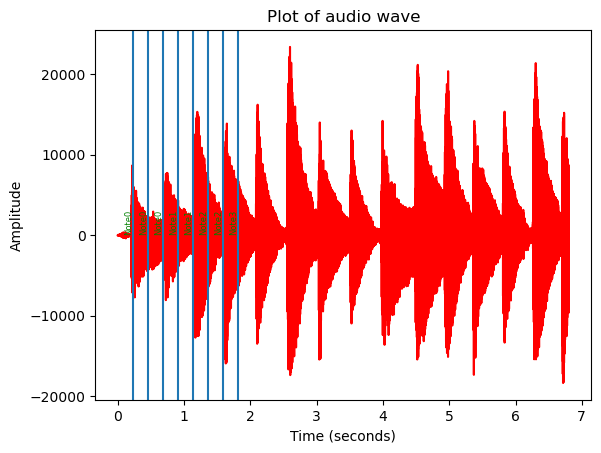

In [ ]:
# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for _, i in enumerate(sample_indices[:8]):
    plt.axvline(i/sample_rate)
    plt.text(sample_indices[_]/sample_rate, 0.3, f'Note{s[_]}', color='green', ha='right', va='bottom', rotation=90, fontsize=6)
    

In [ ]:
# Try again

